In [1]:
import os
import pickle
cache_path = './cache'
path = '/home/baocongidol/Workspace/PTIT/HCSDL_DaPhuongTien/data/v0'
# to store files in a list
list_dirs = []
labels = []
# dirs=directories
for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.png' in f:
            list_dirs.append(f'{root}/{f}')
            label = root.split('/')[-1]
            labels.append(label)

In [2]:
print(f'samples: {len(list_dirs)}')
print(f'labels: {len(set(labels))}')

for lb in list(set(labels)):
    print(f'\t{lb}: \t{labels.count(lb)}')
  

samples: 100
labels: 10
	Dâm Bụt: 	10
	Đồng Tiền: 	10
	Súng Thái: 	10
	Hồng Vàng: 	10
	Thủy Tiên: 	10
	Chi Mão: 	10
	Sen Cạn: 	10
	Vạn Thọ: 	10
	Bồ Công Anh: 	10
	Anh Túc: 	10


In [3]:
# Python code to read image
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt

shapes = []
h = w = 250

def get_threshold(img):
  H,W = img.shape
  h_s = 0
  w_s = 0

  h_e = H
  w_e = W

  for h in range(H):
    for w in range(W):
      if img[h,w] > 0:
        h_s = h
      if h_s!=0: break
    if h_s!=0: break

  for h in reversed(range(H)):
    for w in range(W):
      if img[h,w] > 0:
        h_e = h
      if h_e!=H: break
    if h_e!=H: break

  for w in range(W):
    for h in range(H):
      if img[h,w] > 0:
        w_s = w
      if w_s!=0: break
    if w_s!=0: break
  
  for w in reversed(range(W)):
    for h in range(H):
      if img[h,w] > 0:
        w_e = w
      if w_e!=W: break
    if w_e!=W: break

  return h_s, h_e, w_s, w_e

        
image_arrs = []
labels = []

for dir in tqdm(list_dirs):
  #đọc ảnh xám
  img = cv2.imread(dir, 0)

  #lấy ngưỡng để cắt ảnh
  h_s, h_e, w_s, w_e = get_threshold(img)

  #cắt ảnh, tính từ trung tâm
  crop = img[h_s:h_e, w_s:w_e]
  
  resized = cv2.resize(crop, (500, 500), interpolation = cv2.INTER_AREA)

  #cân bằng sáng
  equ = cv2.equalizeHist(resized)
  
  label = dir.split('/')[-2]
  name = dir.split('/')[-1]

  labels.append(label)

  # print(label)
  # print(dir)
#   os.makedirs(label,exist_ok=True)
#   cv2.imwrite(f'{label}/{name}',equ)
  
  image_arrs.append(equ)
  # shapes.append(crop.shape)
  # break


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]


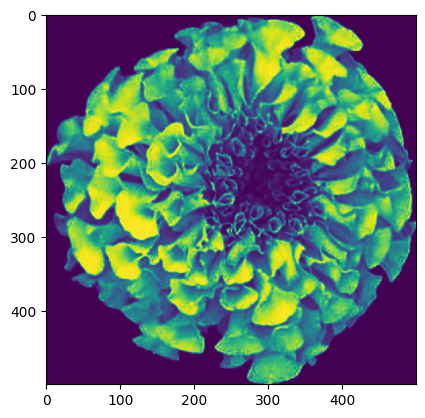

In [4]:
def show_img(img):
    plt.imshow(img)
show_img(image_arrs[60])

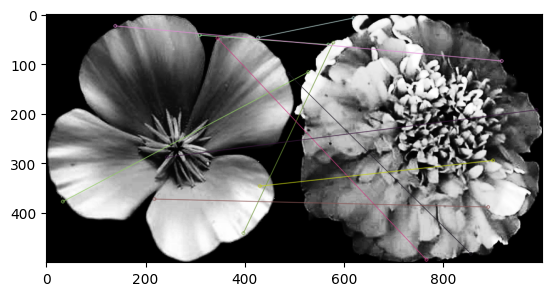

(<matplotlib.image.AxesImage at 0x7f6090510fd0>, None)

In [13]:
import cv2
#sift
sift = cv2.SIFT_create()

img1 = image_arrs[1]
img2 = image_arrs[62]
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.imshow(img3),plt.show()

In [18]:
#khởi tạo label encoder, để convert từ label chữ sang số
from sklearn import preprocessing
try:
    le = pickle.load(open(os.path.join(cache_path,'label_encoder.pkl'), 'rb'))
    print('loaded label encoder')
except:
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    print('create new label encoder')

create new label encoder


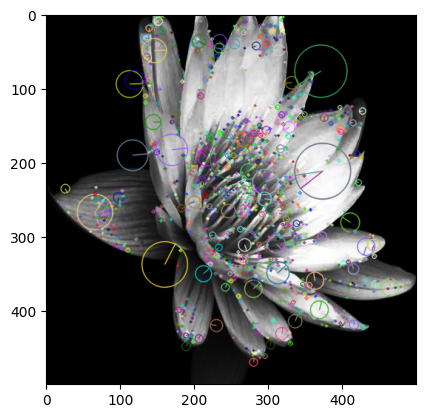

In [25]:
#khởi tạo thuật toán để tách keypoint và descriptor của ảnh
# orb = cv2.BRISK_create(30)
orb = cv2.SIFT_create()
img = image_arrs[57]
keypoint, des = orb.detectAndCompute(img, None)
img_final = cv2.drawKeypoints(img, keypoint, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_img(img_final)

In [26]:
from tqdm import tqdm
#tách descriptor ra khỏi ảnh
descriptors = []
for img in tqdm(image_arrs):
  keypoint, des = orb.detectAndCompute(img, None)
  descriptors.append(des)

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.12it/s]


In [27]:
import numpy as np
print(len(descriptors))
#chuyển gộp tất cả các descriptor thành một ma trận
descriptors_float = np.vstack(descriptors).astype(float)
print(descriptors_float.shape)

100
(152901, 128)


In [30]:
from scipy.cluster.vq import kmeans, vq
#tạo code book với dim = 200 bằng kmean (dùng centroid của thuật toán kmean)
k = 200
try:
    codebook = pickle.load(open(os.path.join(cache_path,'codebook.pkl'), 'rb'))
    print('loaded codebook')
except:
    codebook, variance = kmeans(descriptors_float, k,1)
    print('create new codebook')

create new codebook


In [31]:
from collections import defaultdict
#map các descriptor của ảnh vào code book
im_features = np.zeros((len(descriptors), k), "float32")
for i in range(len(descriptors)):
    words, distance = vq(descriptors[i],codebook)
    for w in words:
        im_features[i][w] += 1

In [32]:
from sklearn.preprocessing import StandardScaler
#chuẩn hóa vector
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#chuyển label chữ thành số
Y = le.transform(labels)

#chia tập train, test với tỉ lệ 70:30
X_train, X_test, y_train, y_test = train_test_split(im_features, Y, test_size=0.3, random_state=42, stratify = Y)

#setup module k neighbor
neigh = KNeighborsClassifier(n_neighbors=5, weights = "distance")
neigh.fit(X_train, y_train)

#predict tập test
preds = neigh.predict(X_test)
accuracy_score(y_test, preds)

0.8

In [52]:
pickle.dump(stdSlr, open(os.path.join(cache_path,'standard_scaler.pkl'), 'wb'))
pickle.dump(codebook, open(os.path.join(cache_path,'codebook.pkl'), 'wb'))